# <center> Chapydette Synthetic Data Example </center>
Chapydette is a fast and flexible change-point detection package. In this notebook we'll take a look at how to use the change-point detection methods in Chapydette to detect change points in synthetic data. We'll also reproduce some results from Arlot, Celisse, and Harchaoui (2019).

## Simple example
First we'll look at how to use Chapydette on a univariate sequence of data. The sequence we'll use was generated according to Scenario 1 of Arlot, Celisse, and Harchaoui (2019).

In [1]:
import numpy as np
import scipy.io

X = scipy.io.loadmat('data/simulated_data_ach_scenario1.mat')['Data'][:, 0]
true_cps = np.array([100, 130, 220, 320, 370, 520, 620, 740, 790, 870])-1

We plot the data below, with the change point locations indicated by the vertical red lines. Here we define a change point to be the *last* observation in a segment.

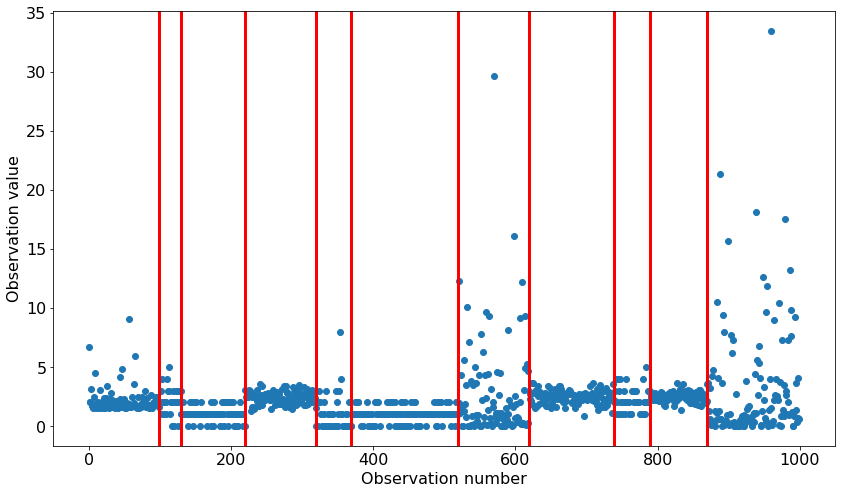

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.scatter(range(len(X)), X)
for cp in true_cps:
    plt.axvline(cp, c='red', lw=3)

plt.xlabel('Observation number', fontsize=16)
plt.ylabel('Observation value', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Now we'll run the kernel change-point estimation algorithm of Harchaoui and Cappé (2007) with the penalty of Arlot, Celisse, and Harchaoui (2019). There are a number of parameters that need to be specified, and these are described in the comments below.

In [3]:
from chapydette import cp_estimation

alpha = 2       # Penalty used in the slope heuristic
bandwidth = 0.1 # Bandwidth used for the kernel
est_ncp = True  # Whether to estimate the number of change points
kernel_type = 'gaussian-euclidean'  # The kernel type. In this case, the Gaussian kernel with the Euclidean 
                                    # distance.
min_cp = 0      # Minimum number of allowable change points in a sequence
max_cp = 100    # Maximum number of allowable change points in a sequence
min_dist = 1    # Minimum allowable distance between change points
return_obj = True  # Whether to return the unpenalized and penalized objective values

X = X[:, np.newaxis]  # The input needs to be 2D
est_cps, all_est_cps, unpenalized_objs, penalized_objs = cp_estimation.mkcpe(X=X, n_cp=(min_cp, max_cp), 
                                                                est_ncp=est_ncp, kernel_type=kernel_type, 
                                                                bw=bandwidth, min_dist=min_dist, 
                                                                return_obj=True)

In this case there are four outputs of mkcpe:
- est_cps: The estimated change points
- all_est_cps: The estimated change points for every number of change points between min_cp and max_cp
- unpenalized_objs: The unpenalized objective values for every number of change points between min_cp and max_cp
- penalized_objs: The penalized objective values for every number of change points between min_cp and max_cp

Let's examine the output!

In [4]:
print('Estimated change points:', est_cps.flatten())
print('True change points:', true_cps.flatten())

Estimated change points: [ 99 129 219 319 369 519 618 738 786 869]
True change points: [ 99 129 219 319 369 519 619 739 789 869]


In the plot below the locations of the true change points are indicated by the red vertical lines and the locations of the estimated change points are denoted by the black dashed lines. The algorithm correctly estimated the number of change points. The estimated change point locations are nearly correct. The estimated change points at indices 618 and 738 are off by one and the estimated change point at index 786 is off by three.

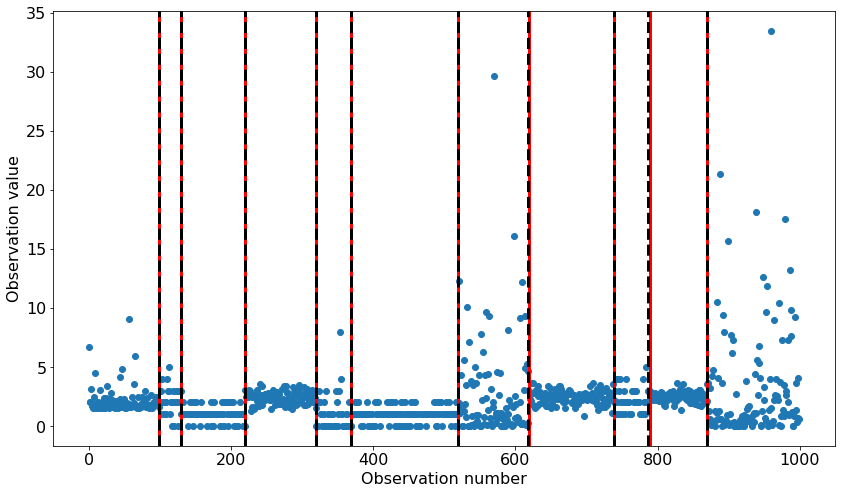

In [5]:
plt.figure(figsize=(14, 8))
plt.scatter(range(len(X)), X)
for cp in true_cps:
    plt.axvline(cp, c='red', lw=3)
for cp in est_cps:
    plt.axvline(cp, ls='--', c='black', lw=3)

plt.xlabel('Observation number', fontsize=16)
plt.ylabel('Observation value', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Finally, we can plot the objective values and the penalized objective values as a function of the estimated number of segments (estimated number of change points + 1). The vertical red line is at the number of (estimated and true) segments.

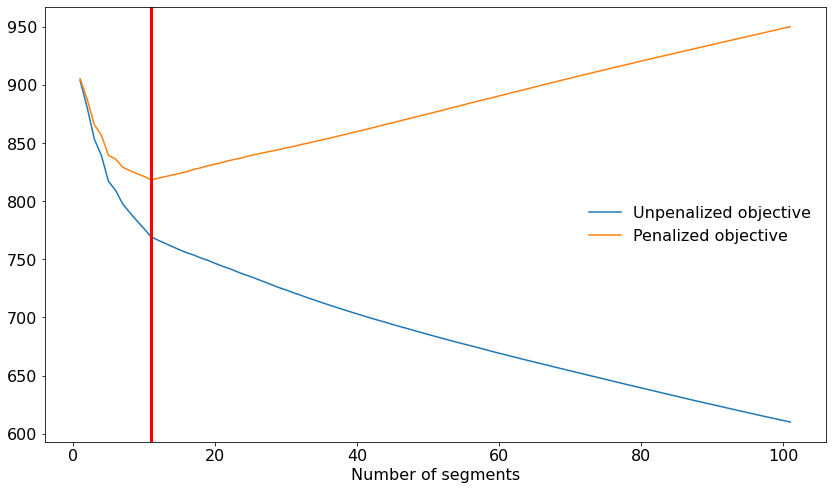

In [6]:
plt.figure(figsize=(14, 8))
plt.plot(range(1, len(unpenalized_objs)+1), unpenalized_objs.values(), label='Unpenalized objective')
plt.plot(range(1, len(penalized_objs)+1), penalized_objs.values(), label='Penalized objective')
plt.axvline(11, c='red', lw=3)
plt.legend(fontsize=16, frameon=False)
plt.xlabel('Number of segments', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## Experiments from Arlot, Celisse, and Harchaoui (2019)
We end by reproducing some of the plots from Arlot, Celisse, and Harchaoui (up to variation from the random seed).

In [7]:
alpha = 2     # Penalty used in the slope heuristic
min_cp = 0    # Minimum number of allowable change points in a sequence
max_cp = 100  # Maximum number of allowable change points in a sequence
min_dist = 1  # Minimum allowable distance between change points
true_cps = np.array([100, 130, 220, 320, 370, 520, 620, 740, 790, 870])-1  # True change points for each seed

In [8]:
def plot_histogram(all_est_ncp, title=None):
    n_est_seg = np.array(all_est_ncp) + 1
    plt.hist(n_est_seg, bins=range(0, max(n_est_seg)+2), align='left', histtype='bar', ec='black', density=True)
    plt.axvline(len(true_cps)+1, ls='--', c='red')
    plt.ylim((0, 0.5))
    plt.xlabel('Number of estimated segments', fontsize=16)
    plt.ylabel('Frequency of selection', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    if title is not None:
        plt.title(title, fontsize=18)

def run_experiment(scenario, kernel_type, bandwidth, alpha, title=None):
    X_all = scipy.io.loadmat('data/simulated_data_ach_scenario' + str(scenario) + '.mat')['Data']
    all_est_ncp = []
    for seed in range(X_all.shape[1]):
        X = X_all[:, seed:seed+1]
        est_cps, _, obj_val, _ = cp_estimation.mkcpe(X=X, gram=None, n_cp=(min_cp, max_cp), est_ncp=True, 
                                                     kernel_type=kernel_type, bw=bandwidth, min_dist=min_dist,
                                                     alpha=alpha, return_obj=True)
        n_est_cps = len(est_cps)
        all_est_ncp.append(n_est_cps)
    plot_histogram(all_est_ncp, title)

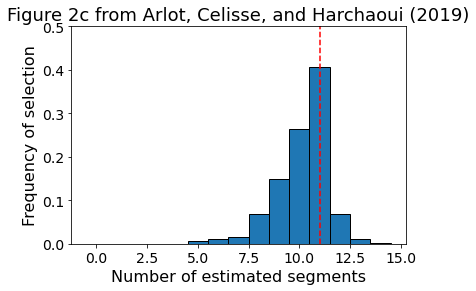

In [9]:
run_experiment(scenario=1, kernel_type='gaussian-euclidean', bandwidth=0.1, alpha=alpha, 
               title='Figure 2c from Arlot, Celisse, and Harchaoui (2019)')

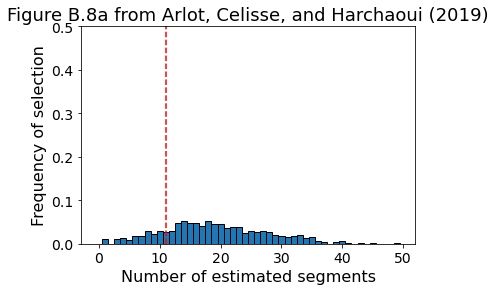

In [10]:
run_experiment(scenario=1, kernel_type='linear', bandwidth=None, alpha=alpha, 
               title='Figure B.8a from Arlot, Celisse, and Harchaoui (2019)')

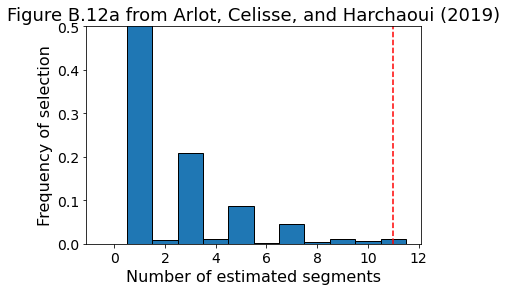

In [11]:
run_experiment(scenario=2, kernel_type='linear', bandwidth=None, alpha=alpha,
               title='Figure B.12a from Arlot, Celisse, and Harchaoui (2019)')

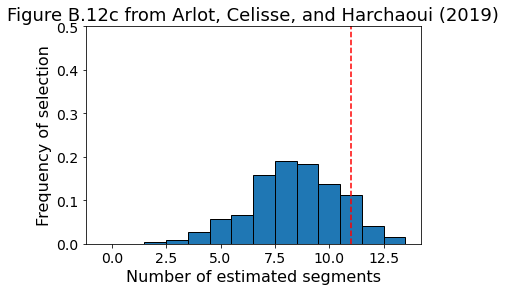

In [12]:
run_experiment(scenario=2, kernel_type='gaussian-euclidean', bandwidth=0.16, alpha=alpha,
               title='Figure B.12c from Arlot, Celisse, and Harchaoui (2019)')

## References
- Z. Harchaoui and O. Cappé. Retrospective mutiple change-point estimation with kernels. In *IEEE Workshop on Statistical Signal Processing*, pages 768–772, 2007.
- S. Arlot, A. Celisse, and Z. Harchaoui. A kernel multiple change-point algorithm via model selection. *Journal of Machine Learning Research*, 20(162):1–56, 2019.